In [1]:
import numpy as np
import astropy.io.fits
from astropy.table import Table
import matplotlib.pyplot as plt
import scipy as sp 
import scipy.integrate as integrate
from scipy import log,exp,sqrt,stats
from astropy import units as u
import astropy.constants as const
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.stats import biweight_location, biweight_scale, bootstrap
from astropy.cosmology import LambdaCDM
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
import scipy.stats as stats
import numpy.ma as ma
from astropy.stats import sigma_clip
from colossus.halo import profile_nfw
cosmo = LambdaCDM(H0=67.77* u.km / u.Mpc / u.s, Om0=0.307115, Ode0=0.692885)  # define cosmology
c=const.c.to("km/s").value
%matplotlib inline

In [2]:
path_2_data = 'massive_cluster0.fit'  # MACS J0717.5+3745  with 202 members 
print('opening', path_2_data)
my_file=astropy.io.fits.open(path_2_data)
#print(my_file[1].data.columns)
data = my_file[1].data

opening massive_cluster0.fit


In [3]:
ra=data.field('ra')  # RA 
dec=data.field('dec') # DEC
zspec=data.field('zspec') # redshift 

# Neglecting nans from the data set
z0=data.field('zspec')
mask0=np.where(z0>0)
z_gal=(zspec[mask0])
len(z_gal)

232

In [4]:
# After the removal of nans from the data
ra_gal=ra[mask0]
dec_gal= dec[mask0]
len(z_gal),len(ra_gal),len(dec_gal)

(232, 232, 232)

# Sigma clipping to remove the interlopers 


In [5]:
clipped_redshift=sigma_clip(z_gal, sigma=1.7, maxiters=10000)

zg=[]
zk=[]
for x in range(len(clipped_redshift)):
    if ma.is_masked(clipped_redshift[x])==False:
        zg.append(clipped_redshift[x])
        
    if not ma.is_masked(clipped_redshift[x])==False:
        zk.append(clipped_redshift[x])
        
    else:
        continue

# mask the remaining dataset according to the filtered members
mask1 = np.where(zg)

RA=(ra_gal[mask1])  # final ra of the member galaxies

DEC=(dec_gal[mask1])   #final dec of the member galaxies

RA_clus= np.mean(RA)  # ra of the cluster

DEC_clus= np.mean(DEC) # dec of the cluster

z_cl=np.mean(zg)
z_cl

0.5426342

# projection of the cluster

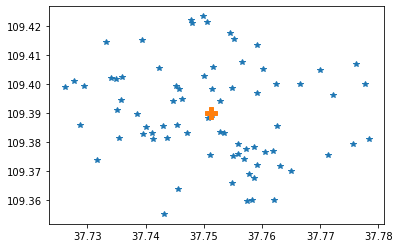

In [6]:
plt.plot(DEC,RA,linestyle='none',marker='*')
plt.plot(DEC_clus,RA_clus,linestyle='none',markersize=12,marker='P')

# 3D distances

In [7]:
#Computing the actual 3D distances between the galaxies and the cluster center
D_cl=cosmo.comoving_distance(zg).value
D_clus=cosmo.comoving_distance(z_cl).value


In [8]:
def get_x_y_z(ra_radian, dec_radian, rr):
    phi   = (ra_radian   - 180 ) * np.pi / 180.
    theta = (dec_radian + 90 ) * np.pi / 180.
    xx = rr * np.cos(phi) * np.sin(theta)
    yy = rr * np.sin(phi) * np.sin(theta)
    zz = rr * np.cos(theta)
    return xx, yy, zz

# Cartesian position of the galaxies
xx, yy, zz = get_x_y_z(RA, DEC, D_cl)
    
# Cartesian position of the galaxies
xx_cl, yy_cl, zz_cl = get_x_y_z(RA_clus, DEC_clus, D_clus)
    
# Getting the distances of the Galaxies with respect to the CLusters

distances = np.array(np.sqrt((xx_cl-xx)**2 + (yy_cl-yy)**2 + (zz_cl-zz)**2))
distances.max()

10.989368137650358

In [12]:
c1 = SkyCoord(RA_clus  *u.deg, DEC_clus *u.deg, distance=D_cl*u.Mpc, frame='icrs')
c2 = SkyCoord(RA*u.deg, DEC *u.deg, distance=D_clus*u.Mpc, frame='icrs')

#commoving distance between Galaxies inside the galaxy cluster
sep = c1.separation_3d(c2)
sep.max()

<Distance 10.98936814 Mpc>

In [13]:
#Physical distance from commoving distance
# D_AB Physical distance to the galaxy B as seen from the galaxy A (ie distance between A and B)
D12 = np.array(sep)/(1+np.array(zg))

#similarly the physical distance D_BA the distance of the galaxy A as seen from B
D21 = np.array(sep)/(1+z_cl)

# Projected distances

In [14]:
# From astropy inbuilt module separation
coordinates_SubHaloes = SkyCoord( RA , DEC , unit='deg', frame='icrs')
coordinate_cluster    = SkyCoord( RA_clus , DEC_clus, unit='deg', frame='icrs') 
Angular_separation_Astropy = coordinates_SubHaloes.separation( coordinate_cluster )
Angular_separation_Astropy_radian = (Angular_separation_Astropy).to(u.radian)
Angular_separation_Astropy_radian.value

# Comoving distance
D = cosmo.comoving_distance(z_cl) 
print('the cluster at redshift ',z_cl,' is at dC=',D)
# Angular diameter distance
print('Angular diameter distance at the clusters redshift :' , cosmo.angular_diameter_distance(z_cl), 'per radian')
print('Angular diameter dist*u.degreeance at the clusters redshift :' , cosmo.angular_diameter_distance(z_cl)/(180/np.pi), 'per degree')
print('Angular diameter distance at the clusters redshift :' , (cosmo.angular_diameter_distance(z_cl)/(180/np.pi)).to(u.kpc)/60, 'per arc minute    ')

#
# The angular separation between sub haloes and the cluster converted in Mpc
r_proj = (Angular_separation_Astropy_radian * cosmo.angular_diameter_distance(z_cl)/u.radian).value  # where D is comoving distance
print('min, max projected distance : ',r_proj.min(), r_proj.max()) #'compared to the 3D virial radius', r_cl/1000)

the cluster at redshift  0.5426342  is at dC= 2087.5787281992257 Mpc
Angular diameter distance at the clusters redshift : 1353.2558418001092 Mpc per radian
Angular diameter dist*u.degreeance at the clusters redshift : 23.618770061259415 Mpc per degree
Angular diameter distance at the clusters redshift : 393.64616768765694 kpc per arc minute    
min, max projected distance :  0.012225951766905005 0.6743543405388321
